## HST cutouts

In [368]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
# from astropy.table import Table
from ccdproc import CCDData, wcs_project
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
# from scipy.interpolate import griddata
from astropy.visualization import AsinhStretch, PercentileInterval, LogStretch
from astropy.nddata import InverseVariance
from astropy.stats import sigma_clipped_stats
from tqdm import tqdm 
from astroscrappy import detect_cosmics

# path = "../data"
# %matplotlib inline

# # For plotting
stretch = LogStretch(10000)
norm    = PercentileInterval(1)

# namecol = "name"
# filt = "i"
example = True
ex = 'J143451+033843'

Get a data table with all the filenames. At thi stage, make any selections as well.

In [366]:
data = pd.read_csv('data/catalogs/hst_control_fileinfo.csv')

# Here select a subset to make cutouts for
sample = data
# sample.head()

Make a cutout, align with North

In [375]:
def make_cutout(path, ra, dec, pxscale=None, size=40, align_north=False, rotate_north=False, crreject=False):

    
    file = fits.open(path)
    ccd  = CCDData.read(path, hdu=1, unit=u.electron/u.s)
    unc = file["WHT"].data
    mask = file['CTX'].data == 0
    wcs = ccd.wcs
    
    # If pixel scale is not known, figure it out from the WCS
    if not pxscale:
        pxscale = np.sqrt(np.abs(np.linalg.det(ccd.wcs.wcs.cd))) # Pixel scale in degrees/px
        pxscale *= 3600 # convert to arcsec/px

    ccd_small = ccd.copy()

    # Reject cosmic rays if needed
    if crreject:
        cr_mask, ccd.data = detect_cosmics(ccd.data*ccd.header['exptime'], gain=ccd.header['ccdgain'], inmask=mask,
                                           sigfrac=0.03, objlim=1)
        ccd.data = ccd.data / ccd.header['exptime']
        mask = mask + cr_mask
        mask[mask > 1]   = 1
        unc[cr_mask > 0] = 0
    
    # Figure out the galaxy center
    cent = skycoord_to_pixel(SkyCoord(ra*u.deg, dec*u.deg), ccd.wcs)
    cent_x, cent_y = int(cent[0]+0.5), int(cent[1]+0.5)

    # Default cutout radius is 40 arcsec
    size = round(size/pxscale)
        
    # Now create the cutout
    xmin = max(0, cent_x-size); xmax = min(cent_x+size, ccd.data.shape[1])
    ymin = max(0, cent_y-size); ymax = min(cent_y+size, ccd.data.shape[0])


    # Make a cutout (this might not be a square or centered on the object due to possible image borders)
    slices = (slice(ymin, ymax), slice(xmin, xmax))
    data  = ccd.data[slices]
    unc = unc[slices]
    mask = mask[slices]
    
    # Pad the array to a desired size
    padx = (max(0,size-cent_x), max(cent_x+size-ccd.data.shape[1], 0))
    pady = (max(0,size-cent_y), max(cent_y+size-ccd.data.shape[0], 0))
    data = np.pad(data, (pady, padx))
    unc = np.pad(unc, (pady, padx))
    mask = np.pad(mask, (pady, padx), constant_values=1)
    slices = (slice(cent_y-size, cent_y+size), slice(cent_x-size, cent_x+size))
    
    # Estimate sky
    sky = sigma_clipped_stats(data)
    data -= sky[1]
    
    # Create the cutout CCD
    ccd_small.data = data
    ccd_small.uncertainty = InverseVariance(unc)
    ccd_small.mask = mask
    
    
    ccd_small.wcs   = wcs.slice(slices)
    ccd_small.header["x_og"] = cent_x
    ccd_small.header["y_og"] = cent_y
    
    imcent = skycoord_to_pixel(SkyCoord(ra*u.deg, dec*u.deg), ccd_small.wcs)
    ccd_small.wcs.wcs.crpix = imcent
    ccd_small.wcs.wcs.crval = np.array([ra, dec])
    
    ccd_small.header["x_og"] = cent_x
    ccd_small.header["y_og"] = cent_y
    ccd_small.header["zp"] = -2.5*np.log10(file['SCI'].header["PHOTFLAM"]) + file['SCI'].header["PHOTZPT"]
    ccd_small.header['pxscale'] = pxscale
    
    # Rotate the image to align it with North (optional)
    if align_north:
        wcs = ccd_small.wcs.deepcopy()
        wcs.wcs.cd = np.array([[0,pxscale/3600],[pxscale/3600,0]])
        ccd_small.data = ccd_small.data.T[::-1]
        ccd_small.uncertainty = InverseVariance(unc.T[::-1])
        ccd_small.mask = mask.T[::-1]
    # Rotate the image to align it with North when the rotation is a simple flip
    elif rotate_north:
        wcs = ccd_small.wcs.deepcopy()
        wcs.wcs.cd = np.array([[0,pxscale/3600],[pxscale/3600,0]])
        
        ccd_rot = wcs_project(ccd_small, wcs)
        
        tmp = ccd_small.copy()
        tmp.data = unc
        ccd_rot.uncertainty = InverseVariance(wcs_project(tmp, wcs).data)

        tmp.data = 1-mask
        mask = wcs_project(tmp, wcs, order='nearest-neighbor').data
        mask = (mask < 0.5) | np.isnan(mask)
        ccd_rot.mask = mask
        
        ccd_small = ccd_rot

    return ccd_small

Example:

INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_7225/1604520763.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(ccd.data)))


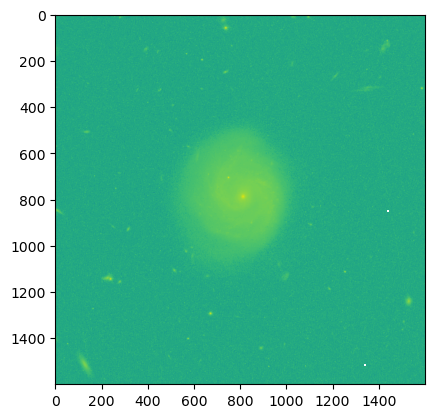

In [372]:
if example:
    
    info = sample[sample['name'] == ex].iloc[0]
    file = fits.open(f'data/hst/raw/{info.filename}_drz.fits')
    ccd = make_cutout(f'data/hst/raw/{info.filename}_drz.fits', info.ra, info.dec, align_north=True, crreject=False)
    plt.imshow(np.log10(np.abs(ccd.data)))

In [377]:
for idx, row in tqdm(sample.iloc[48:].iterrows(), total=len(sample)):
    
    # print(row['name'])
    ccd = make_cutout(f'data/hst/raw/{row.filename}_drz.fits', row.ra, row.dec, align_north=True, crreject=False)
    hdu = ccd.to_hdu()
    hdu.writeto(f"data/hst/F814W/{row['name']}.fits", overwrite=True)
    
    
    try:
        fig = plt.figure(figsize=(10,10))
        plt.imshow(stretch(norm(ccd)))
        plt.savefig(f"data/hst/png/{row['name']}.png", bbox_inches="tight")
        plt.close(fig)
    except:
        print(f"======================== \n ERROR IN {row['name']}")

  0%|                                                                        | 0/52 [00:00<?, ?it/s]

INFO: using the unit electron / s passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata]


  2%|█▏                                                              | 1/52 [00:02<02:06,  2.49s/it]

INFO: using the unit electron / s passed to the FITS reader instead of the unit COUNTS/S in the FITS file. [astropy.nddata.ccddata]


  4%|██▍                                                             | 2/52 [00:03<01:07,  1.36s/it]

INFO: using the unit electron / s passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata]


  6%|███▋                                                            | 3/52 [00:04<01:11,  1.46s/it]

INFO: using the unit electron / s passed to the FITS reader instead of the unit ELECTRONS/S in the FITS file. [astropy.nddata.ccddata]


  8%|████▉                                                           | 4/52 [00:06<01:14,  1.55s/it]
